# Exercise: What is the classifier picking up on with the top-2 results? 

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import re
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE

import sklearn
from sklearn.inspection import permutation_importance


In [2]:
# version = 'old'
version = 'clare_basis'
# version = 'clare_all'


In [3]:
if version == 'old':
    fn = 'lfc_mb_filt_OLD.csv' ## data set without Claire's screens
elif version == 'clare_all':
    fn = 'lfc_mb_filt.csv' ## data set with all of Claire's pairwise combinations
elif version == 'clare_basis':
    fn = 'lfc_mb_filt_BASIS.csv' ## data set only Claire's mutant vs. wildtype screens

path = '../data/standardized_data/cleaned_ML/'
df_lfc = pd.read_csv(os.path.join(path, fn))
df_lfc.shape

(2937, 127)

In [4]:
# X and y
cols_data = df_lfc.columns[1:-1]
X = df_lfc[cols_data].to_numpy()
print(X.shape)

list_categories = df_lfc.Functional_Category.unique().tolist()
list_categories

(2937, 125)


['information pathways',
 'cell wall and cell processes',
 'intermediary metabolism and respiration',
 'regulatory proteins',
 'virulence, detoxification, adaptation',
 'insertion seqs and phages',
 'lipid metabolism',
 'PE/PPE']

## Feature importance analysis: 

In [5]:
# model = 'xgbc'

In [132]:
def get_important_screens(df_lfc, category):   
    
    model = 'logreg'
    n_splits = 5
    n_classes = 2
    shuffle = False

    # 'insertion seqs and phages' # 'insertion seqs and phages' 
    y = np.zeros(df_lfc.shape[0])
    ind_ones = [i for i in range(df_lfc.shape[0]) if df_lfc.iloc[i].Functional_Category == category]
    y[ind_ones] = 1

    if shuffle: # shuffle y vector.
        random.shuffle(y)

    if model == 'logreg':
        reg_param_temp = 1e-1
        clf = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=reg_param_temp)
    elif model == 'xgbc':
        clf = XGBClassifier(gamma = reg_param_temp, reg_alpha=1, reg_lambda=1)

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    list_top_screens = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train, y_train = SMOTE().fit_resample(X_train, y_train) # understand this step. 
        # fit model
        clf.fit(X_train, y_train)

    #     importance = clf.coef_[0]

        results = permutation_importance(clf, X, y, scoring='roc_auc') # scoring = 'neg_log_loss', 'accuracy'
        importance = results.importances_mean

        ind_top10 = np.argsort(np.abs(importance))[-10:] # why the top 10? 
        top_screens = cols_data[ind_top10[::-1]].tolist()
        list_top_screens+=top_screens

    set_screens = set(list_top_screens)
    dict_screen_counts = {}
    for screen in set_screens:
        dict_screen_counts[screen] = list_top_screens.count(screen)
    # {k: v for k, v in sorted(dict_screen_counts.items(), key=lambda item: item[1])}
    return dict_screen_counts

In [155]:
category = 'insertion seqs and phages'
df_lfc[df_lfc.Functional_Category == category].Rv_ID.values

array(['Rv0031', 'Rv0094c', 'Rv0095c', 'Rv0336', 'Rv0393', 'Rv0397',
       'Rv0515', 'Rv0605', 'Rv0606', 'Rv0741', 'Rv0755A', 'Rv0795',
       'Rv0796', 'Rv0797', 'Rv0829', 'Rv0850', 'Rv0920c', 'Rv0921',
       'Rv0922', 'Rv1034c', 'Rv1035c', 'Rv1036c', 'Rv1041c', 'Rv1042c',
       'Rv1047', 'Rv1054', 'Rv1055', 'Rv1128c', 'Rv1148c', 'Rv1199c',
       'Rv1313c', 'Rv1369c', 'Rv1370c', 'Rv1572c', 'Rv1573', 'Rv1574',
       'Rv1576c', 'Rv1577c', 'Rv1578c', 'Rv1579c', 'Rv1580c', 'Rv1581c',
       'Rv1582c', 'Rv1583c', 'Rv1584c', 'Rv1585c', 'Rv1586c', 'Rv1587c',
       'Rv1588c', 'Rv1701', 'Rv1702c', 'Rv1756c', 'Rv1757c', 'Rv1763',
       'Rv1764', 'Rv1765A', 'Rv1945', 'Rv2013', 'Rv2014', 'Rv2085',
       'Rv2086', 'Rv2087', 'Rv2100', 'Rv2105', 'Rv2106', 'Rv2167c',
       'Rv2168c', 'Rv2177c', 'Rv2278', 'Rv2279', 'Rv2309c', 'Rv2310',
       'Rv2354', 'Rv2355', 'Rv2424c', 'Rv2479c', 'Rv2480c', 'Rv2512c',
       'Rv2646', 'Rv2647', 'Rv2648', 'Rv2649', 'Rv2650c', 'Rv2651c',
       'Rv2652c', '

In [152]:
def median_screens_category(df_lfc, category, top_screens):
    
    list_median_all = []
    list_median_class = []
    for screen in top_screens:
        data_all = df_lfc[screen].values
        data_class = df_lfc[df_lfc.Functional_Category == category][screen].values
        list_median_class.append(np.median(data_class))
        list_median_all.append(np.median(data_all))
             
    plt.figure(figsize=(8,8))
    xymin, xymax = -0.6, 0.6
    xyrange = np.linspace(xymin, xymax, 100)
    plt.xlim(xymin, xymax)
    plt.ylim(xymin, xymax)
    plt.plot(xyrange, xyrange, 'k--')
    
    for i in range(len(list_median_all)):
        plt.scatter(list_median_all[i], list_median_class[i], s = 300, edgecolors='k', linewidths=3, alpha=0.75)
    
#     plt.legend(['x=y line']+top_screens)
    plt.xlabel('median lfc across all genes', fontsize = 18)
    plt.ylabel('median lfc across genes in class', fontsize = 18)
    plt.title(category, fontsize = 18)
    plt.tight_layout()
    
    fig_path = '../figures/Adrian_classification/'
    plt.savefig(os.path.join(fig_path, 'median_class_vs_all_'+category.split()[0].split('/')[0]+'.png'), dpi = 300)

information pathways
cell wall and cell processes
intermediary metabolism and respiration
regulatory proteins
virulence, detoxification, adaptation
insertion seqs and phages
lipid metabolism
PE/PPE


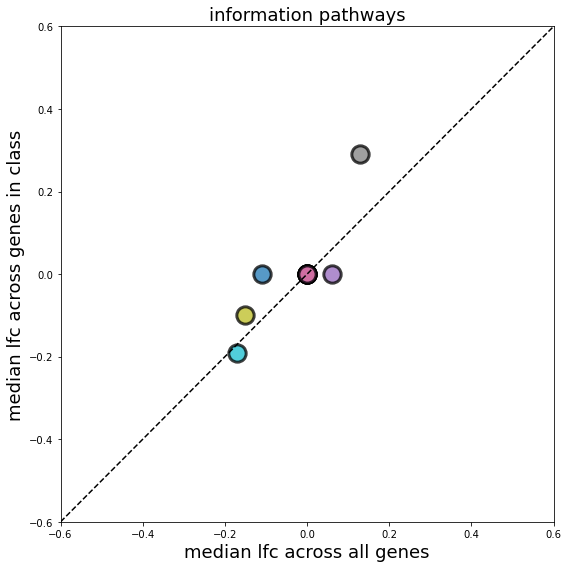

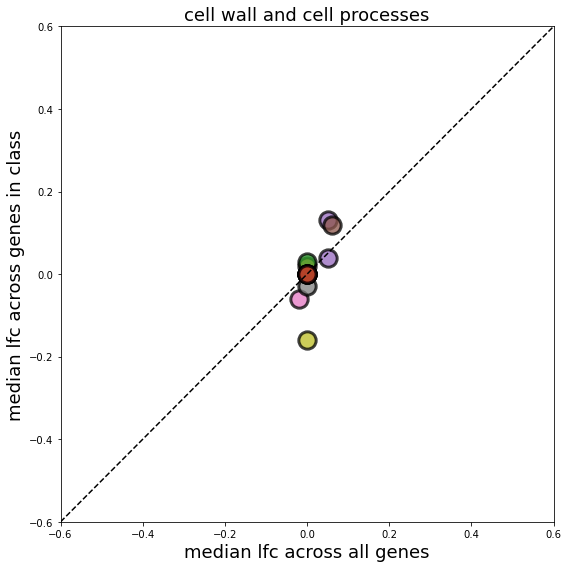

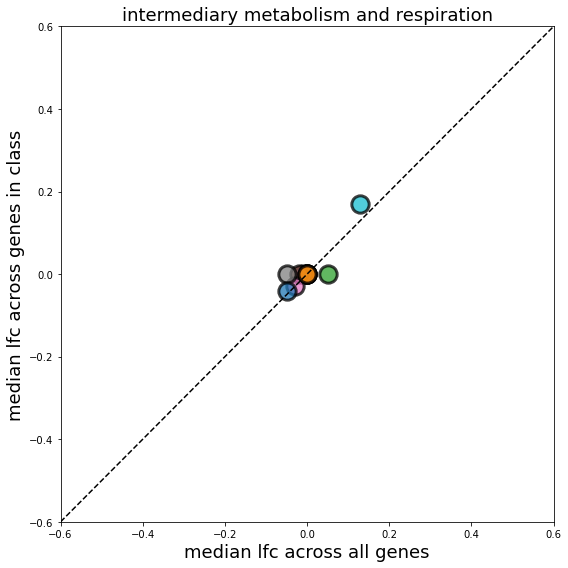

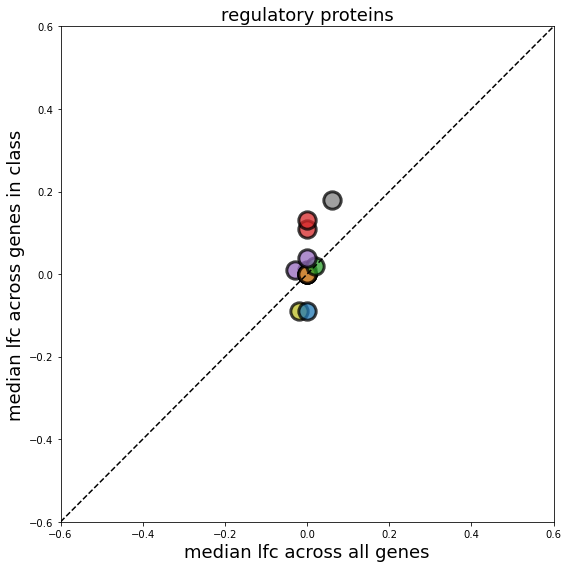

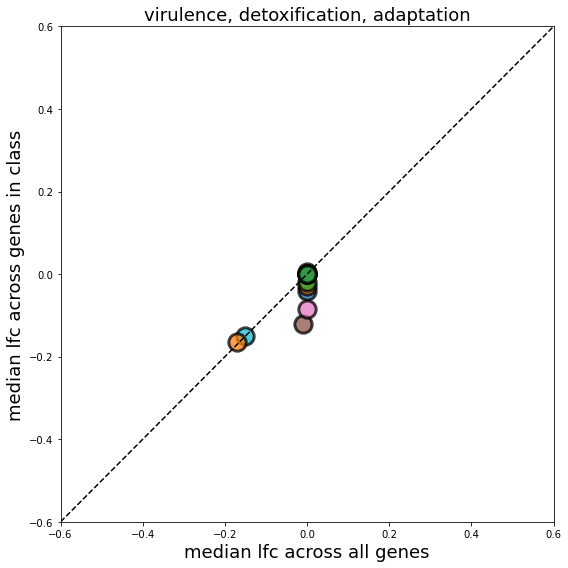

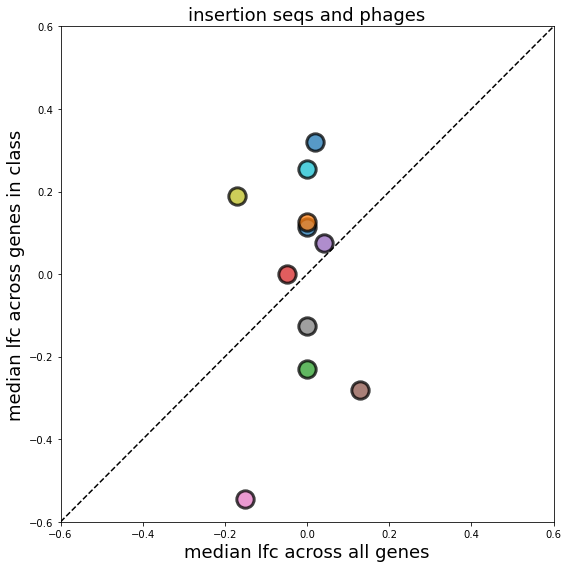

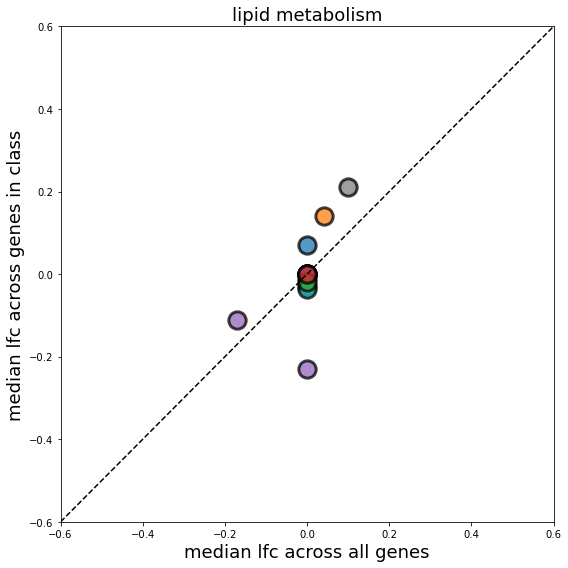

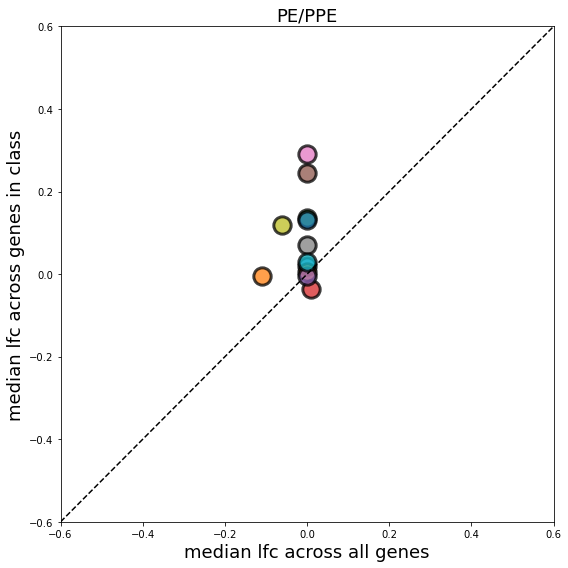

In [153]:
th = 2
# category = 'PE/PPE'
for category in df_lfc.Functional_Category.unique():
    print(category)
    dict_screen_counts = get_important_screens(df_lfc, category)
    top_screens = [k for k in dict_screen_counts.keys() if dict_screen_counts[k]>= th]
    median_screens_category(df_lfc, category, top_screens)

(-1.5, 1.5)

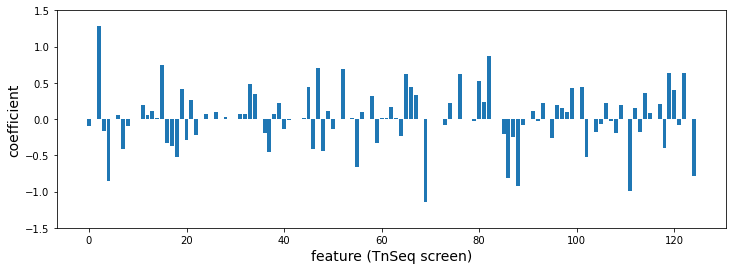

In [7]:
plt.figure(figsize=(12, 4))
plt.bar([x for x in range(len(importance))], importance)
plt.xlabel('feature (TnSeq screen)', fontsize=14)
yl = plt.ylabel('coefficient', fontsize=14)
plt.ylim(-1.5, 1.5)

Version 2: permutation importance: 

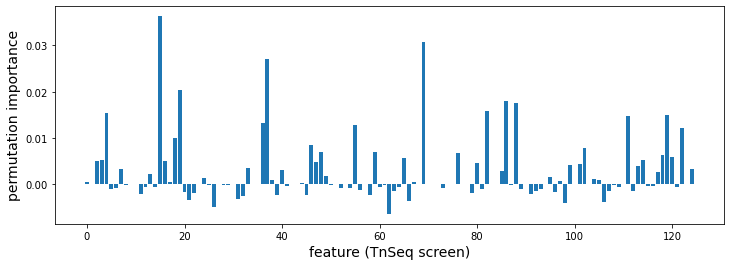

In [10]:
results = permutation_importance(clf, X, y, scoring='accuracy') # scoring = 'neg_log_loss'
importance_perm = results.importances_mean
plt.figure(figsize=(12, 4))
plt.bar([x for x in range(len(importance_perm))], importance_perm)
plt.xlabel('feature (TnSeq screen)', fontsize=14)
yl = plt.ylabel('permutation importance', fontsize=14)

In [11]:
ind_top10 = np.argsort(np.abs(importance_perm))[-10:]
cols_data[ind_top10[::-1]]

Index(['carey_631_vs_carey_rv', 'CC003.Unc_vs_C57BL.6J',
       'kieser_dPonA1_vs_mbio_H37Rv', 'carey_663_vs_carey_rv',
       'CC022.GeniUnc_vs_C57BL.6J', 'CC024.GeniUnc_vs_C57BL.6J',
       'CC017.Unc_vs_C57BL.6J', 'Rv1096_KO_vs_CB_WT', 'NZO.H1LtJ_vs_C57BL.6J',
       'CC057.Unc_vs_C57BL.6J'],
      dtype='object')

## lfc distributions: 

In [44]:
category = 'PE/PPE'
screen = 'CC022.GeniUnc_vs_C57BL.6J'

cumulative distribution:

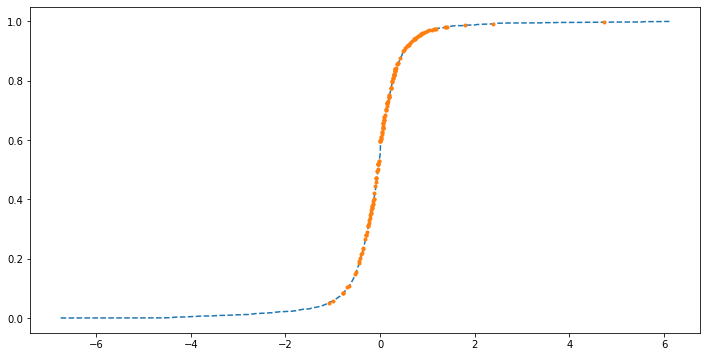

In [156]:
plt.figure(figsize=(12, 6))
plt.plot(xrange, cumdist_all, '--')
plt.plot(data_class, cumdist_class, '.')

## alternative insights: 

In [157]:
fn_up_func = '../data/tests/uniprot-proteome_UP000001584.xlsx'
df_up_func = pd.read_excel(fn_up_func)

/home/ajinich/miniconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [159]:
re_str = 'Rv\d\d\d\dc?'
list_rvids = [re.findall(re_str, str_temp)[0] for str_temp in df_up_func['Gene names']]
df_up_func['Rv_ID'] = list_rvids
df_up_func['annot_int'] = [int(annot.split()[0]) for annot in df_up_func.Annotation]
# df_up_func = df_up_func[['Rv_ID', 'annot_int', 'Gene names', 'Function [CC]']].copy()

In [162]:
df_lfc_UP = df_lfc.merge(df_up_func, on = 'Rv_ID', how = 'inner')

In [185]:
category = 'PE/PPE'
prot_len_cat = df_lfc_UP[df_lfc_UP.Functional_Category == category].Length.values
prot_len_all = df_lfc_UP.Length.values

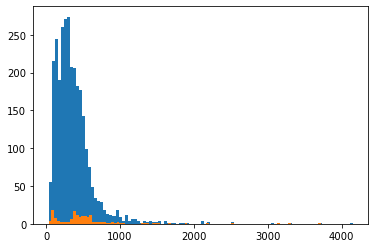

In [186]:
hst = plt.hist(prot_len_all, 100)
hst = plt.hist(prot_len_cat, 100)

In [187]:
np.median(prot_len_cat)

462.0

In [188]:
np.median(prot_len_all)

312.0

In [180]:
category = 'insertion seqs and phages'
df_lfc_UP[df_lfc_UP.Functional_Category == category][['Rv_ID', 'Length', 'annot_int', 'Gene names', 'Function [CC]']].sort_values(by = 'annot_int', ascending = False).head(10)

,Rv_ID,Length,annot_int,Gene names,Function [CC]
2135,Rv2894c,298.0,3,xerC Rv2894c MTCY274.25c,"FUNCTION: Site-specific tyrosine recombinase, ..."
1328,Rv1701,311.0,3,xerD Rv1701 MTCI125.23,"FUNCTION: Site-specific tyrosine recombinase, ..."
2128,Rv2886c,295.0,2,Rv2886c MTCY274.17c,NaN
2530,Rv3428c,410.0,2,Rv3428c MTCY78.01,NaN
1022,Rv1313c,444.0,2,Rv1313c MTCY373.33c; Rv3798 MTV026.03,NaN
929,Rv1199c,415.0,2,Rv1199c MTCI364.11c; Rv2512c MTCY07A7.18c,FUNCTION: Required for the transposition of th...
892,Rv1148c,454.0,2,Rv1148c MTCI65.15c,NaN
2069,Rv2791c,459.0,2,Rv2791c,NaN
1982,Rv2659c,375.0,2,Rv2659c,FUNCTION: Integrase is necessary for integrati...
2351,Rv3191c,344.0,2,Rv3191c,NaN
